The **Expectation-Maximization (EM) Clustering** algorithm is another popular clustering algorithms used in machine learning. The goal of EM Clustering is to maximize the likelihood of the underlying sub-distributions in a given dataset by estimating the parameters those distributions. Similarly to the **k-Means** algorithm it is often used (1) to **confirm business assumptions** about what types of groups exist or (2) to **identify unknown groups** in complex data sets. Some examples of business-related use cases are:

>- Segment customers by purchase history;
>- Segment users by activities on an application or a website;
>- Group inventory by sales activity; or,
>- Group inventory by manufacturing metrics.


# 0. LIBRARIES IMPORT

In [3]:
# import the pandas data science library
import pandas as pd
import numpy as np

# import the scipy spatial distance capability
from scipy.spatial.distance import cdist

# import sklearn data sample generator libraries
from sklearn.datasets import make_blobs

# import sklearn k-means and gaussian-mixture classifier library
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# import matplotlib data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import matplotlibs 3D plotting capabilities
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.style.use('seaborn')
%matplotlib inline
random_seed = 42

# 1. K-MEANS LIMITATION




"One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster" (Jake VanderPlas, The Python Data Science Handbook). To investigate this limitation of the **k-Means Clustering** algorithm let's have a closer look at an exemplary very skewed data distribution.

Let's create a very skewed distribution that exhibits a eliptical characteristic:

In [5]:
# generate a sample data distribution
data, labels = make_blobs(n_samples = 1000, centers = 3, cluster_std = .7, random_state = 0)

# init the random state and skew the data
random_state = np.random.RandomState(8)
data_skewed = np.dot(data, random_state.randn(2, 2))

Once created, let's visualize the skewed distribution accordingly:

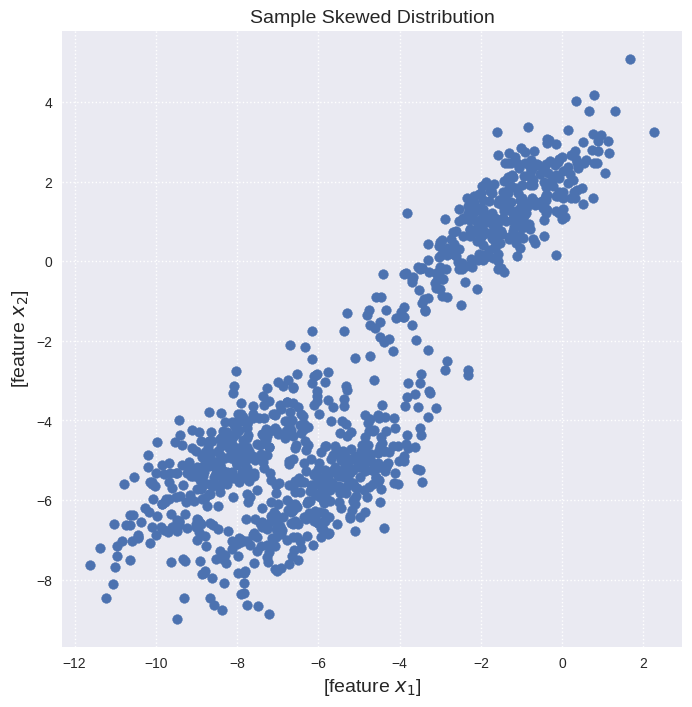

In [6]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the two dimensions of the skewed distribution
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1])

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution', fontsize=14);

Ok, the distribution looks indeed very skewed. It furthermore seem to consist of three commingled eliptical clusters. Let's see if we can identify those clusters using the k-Means Clustering algorithm that we discussed before:

In [7]:
# init the k-Means Clustering algorithm
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=100)

# fit the clustering to the the data
kmeans.fit(data_skewed)

# obtain the cluster labels
kmeans_labels_skewed = kmeans.labels_

# obtain the cluster means
kmeans_means_skewed = kmeans.cluster_centers_

Let's now visualize the results of the clustering as well as the obtained clusters:

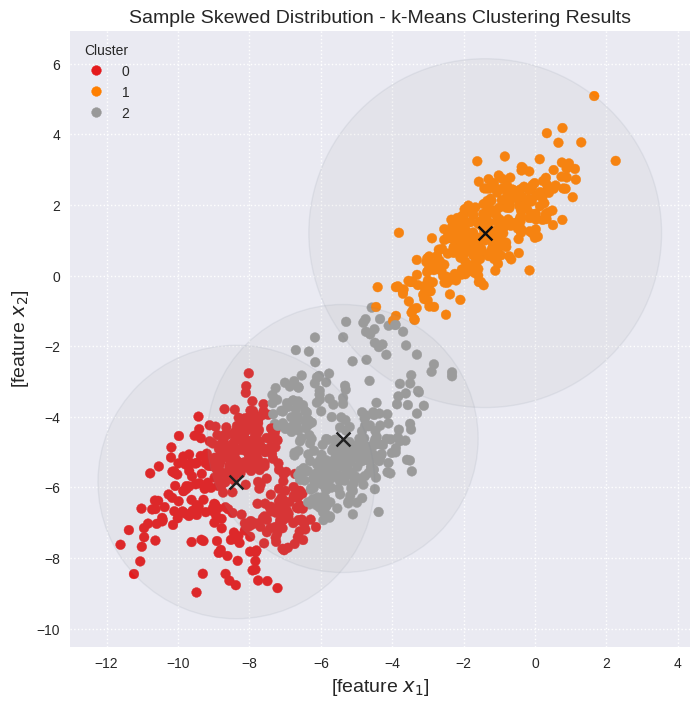

In [9]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot petal length vs. petal width and corresponding classes
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=kmeans_labels_skewed, cmap=plt.cm.Set1)

# prepare data legend
ax.legend(*scatter.legend_elements(), loc='upper left', title='Cluster')

# plot cluster means
ax.scatter(kmeans_means_skewed[:,0], kmeans_means_skewed[:,1], marker='x', c='black', s=100)

# iterate over distinct cluster means
for i, mean_skewed in enumerate(kmeans_means_skewed):

    # determine max cluster point distance
    cluster_radi = cdist(data_skewed[:, 0:2][kmeans_labels_skewed==i], [mean_skewed]).max()

    # plot cluster size
    ax.add_patch(plt.Circle(mean_skewed, cluster_radi, fc='darkgrey', edgecolor='slategrey', lw=1, alpha=0.1, zorder=1))

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - k-Means Clustering Results', fontsize=14);

Based on the example above we observe one of the main disadvantages of the **k-Means Clustering** algorithm. The k-Means Clustering has no way to account for oblong or elliptical clusters. Therefore, it fails to recognize the distinct clusters in very skewed distributions.

Unlike the k-Means Clustering algorithm, the **Expectation Maximization (EM)** algorithm (introduced in the following section of the notebook) is not limited to spherical shapes. Using the EM algorithm we can constrain the algorithm to provide different covariance matrices (spherical, diagonal and generic). These different covariance matrices in return allow to control the shape of our clusters and hence we can detect sub-populations in our data with different characteristics.

# 2. EXPECTATION MAXIMIZATION

## a. algorithm understanding

The **Expectation Maximization (EM)** algorithm is similar to the k-Means Clustering technique. However, instead of assigning examples to clusters to maximize the differences in means, the EM Clustering algorithm computes probabilities of cluster memberships based on one or more probability distributions.

The goal of the clustering algorithm then is to maximize the overall probability or likelihood of the data, given the (final) clusters. Thereby, the objective of EM clustering is to estimate the means and standard deviations for each cluster so as to maximize the likelihood of the observed data (distribution). To achieve this objective the algorithm iteratively computes an **(1) Expectation-Step** and **(2) Maximization-Step** as described in the following:

### i. 1st step: The Expectation-Step

In the **"Expectation Step"** we determine the expected values $E(z_{ij} | \mu_{j}^{t}, \sigma_{j}^{t})$ that denotes the probability of a given observation $x_i \in \mathcal{R}^d$ that it was drawn from the $j^{th}$ distribution (or cluster):

$$E(z_{ij}) = \frac{P(x_i|\mu_{j}^{t}, \sigma_{j}^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})},$$

were:

- $x_i \in X$ denotes a particular data observation;
- $t$ denotes the current iteration of the EM Clustering algorithm;
- $\mu_j$ and $\sigma_j$ denotes the mean and (co-) variance of the $j^{th}$ distribution (or cluster).

The probability distribution of each cluster might be approximated by a Gaussian (Normal) probability distribution $\mathcal{N}(\mu, \sigma)$. Hence the approach is usually referred to as the **EM-Algorithm of Gaussian Mixtures**. This simplification is justified by the application of the **"law of large numbers"** or **"Central Limit Theorem"**. In general, the probability density of a Gaussian "Normal" distribution, as defined by the formula below. It is parametrized its mean $\mu$ and corresponding standard deviation $\sigma$:

$$ P(x|\mu,\sigma)  \approx \mathcal{N}(x|\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma^{2}}(x - \mu)^2}$$

Using the **Central Limit Theorem** we can rewrite the formula of the Expectation Step as:

$$E(z_{ij}) = \frac{P(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k P(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{\mathcal{N}(x_i|\mu_j^{t}, \sigma_j^{t})}{\sum_{k'=1}^k \mathcal{N}(x_i|\mu_{k'}^{t},\sigma_{k'}^{t})} = \frac{ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma_{j}^{t 2}}(x_i - \mu_{j}^{t})^2} }{ \sum_{k'=1}^{k} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2\sigma_{k'}^{t 2}}(x_i - \mu_{k'}^{t})^2} }$$

The distinct $E(z_{ij})$ values $z_{1j}$, $z_{2j}$, ..., $z_{nj}$ represent the probability distribution of the $j^{th}$ cluster that the data point is drawn from. Understanding the range of values the $z$ values can take is important. Each observation $x_i$ has k associated $E(z_{ij})$ values. In the **k-Means Clustering** algorithm each $z_{ij}$ can only take the value 0 or 1. This is why the k-Means Clustering algorithm is referred to as **"hard"** clustering.

In contrast, the **"EM-Clustering"** algorithm is referred to as **"soft"** or **"fuzzy"** clustering. In EM-Clustering the distinct observations $x_i$ are considered to be drawn probabilistically from the distinct cluster distributions $j$. The corresponding $z_{ij}$ values can therefore be $z_{i1}$=0.85, $z_{i2}$=0.10 and $z_{i3}$=0.05, which represents a strong probability that the $x_{i}$ value originates from distribution (or cluster) 1 and a exhibit a smaller probability that it originates from distribution (or cluster) 2 or 3.

### ii. 2nd step: The Maximization-Step

In the **"Maximization-Step"** we calculate update the parameters of each Gaussian "Normal" cluster distribution. Therefore, we derive for each $j^{th}$ distribution (or cluster) a new $\mu_{j}$ and $\sigma_{j}$ parameter value as given by:

$$ \mu_{k}^{t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij})x_i} {\sum_{k'=1}^{k}E(z_{ij})}; \sigma_{j}^{2, t+1} = \frac {\sum_{k'=1}^{k}E(z_{ij}) (x_i - \mu_{k}^{t})^{2}} {\sum_{k'=1}^{k}E(z_{ij})}$$

## b. EM in 2-D feature space

Similarly, to k-Means Clustering let's now define the parameters of the **EM-Clustering** algorithm. We will start by specifying the **number of clusters** $k$ we aim to detect in the iris dataset. We again hypothesize that our observations are drawn from an unknown distributions of three iris flower species (each distribution corresponding to a different mean $\mu_1$, $\mu_2$, and, $\mu_3$ and corresponding standard deviation $\sigma_1$, $\sigma_2$, and, $\sigma_3$). Therefore, we set the number of clusters to be detected to $k=3$:

In [10]:
no_clusters = 3

Next, we need to define a corresponding number of **initial 'means' $\mu_{i}$** (the initial random cluster centers) that will be used as 'starting points' in the first iteration of the clustering process. In our case we will specify $k=3$ cluster means each of dimension 2, since we aim to retrieve 3 clusters based on the 2 features $x_1$ and $x_2$:

In [11]:
init_means = np.array([[1.0, 3.0], [2.0, 6.0], [1.0, 7.0]])

Finally, we will define a **maximum number of iterations** that we want to run the **EM-Clustering** algorithm. Please, note that the clustering terminates once there will be no further changes in the cluster assignments. However, it's good practice to define an upper bound of the iterations applied in the clustering (especially when analyzing datasets that exhibt a high-dimensional feature space):

In [12]:
max_iterations = 50

In [15]:
# initialize
em = GaussianMixture(n_components=no_clusters, means_init=init_means, max_iter=max_iterations)

Let's run the **EM-Clustering** to learn a model of the $x_1$ and $x_2$ features. Similar to the k-Means Clustering we will again make use of the `fit()` method provided by `sklearn` for each of its classifiers:

In [16]:
#fit
em.fit(data_skewed)

GaussianMixture(max_iter=50,
                means_init=array([[1., 3.],
       [2., 6.],
       [1., 7.]]),
                n_components=3)

Now that we have conducted the clustering, let's inspect the distinct cluster labels that have been assigned to the individual records of our artificial dataset. This can be achieved by calling the `predict()` function of the fitted model:

In [17]:
em_labels_skewed = em.predict(data_skewed)

Furthermore, we want to inspect the coordinates of the cluster means (sometimes also referred to as "centroids") assigned by the algorithm. This can be achieved by calling the `means_`attribute of the fitted model:

In [18]:
em_means_skewed = em.means_

Let's now visually inspect the clustering results of the two features $x_1$ and $x_2$ in terms of the cluster assignments of each observation and cluster means learned by the **EM-Clustering** algorithm:

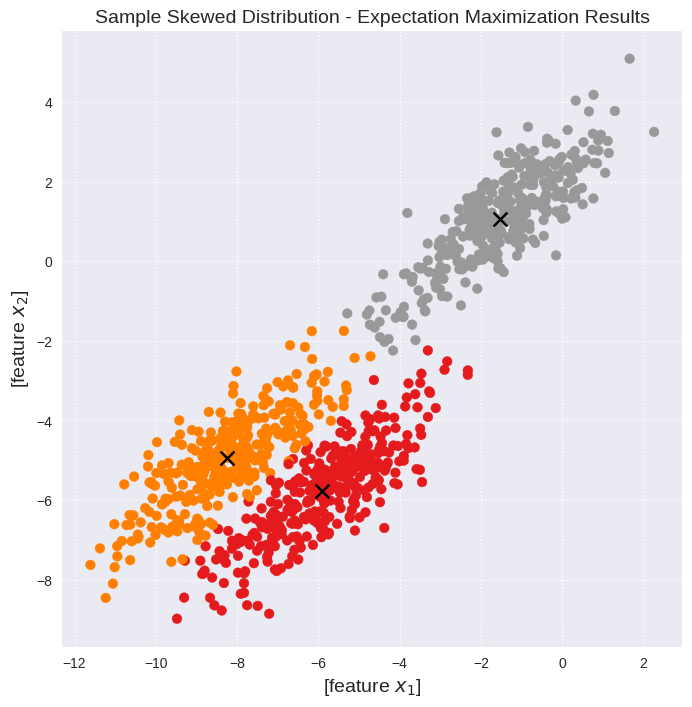

In [20]:
# init the plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot x_1 vs. x_2 and corresponding cluster labels
scatter = ax.scatter(data_skewed[:,0], data_skewed[:,1], c=em_labels_skewed, cmap=plt.cm.Set1)

# plot cluster means
ax.scatter(em_means_skewed[:,0], em_means_skewed[:,1], marker='x', c='black', s=100)

# add axis legends
ax.set_xlabel("[feature $x_1$]", fontsize=14)
ax.set_ylabel("[feature $x_2$]", fontsize=14)

# add plot title
plt.title('Sample Skewed Distribution - Expectation Maximization Results', fontsize=14);

Ok, we can observe that the **EM Clustering** technique nicely clusters the distinct distributions of the skewed distributions. We notice that the results are quite different from those computed by the k-Means clustering. As initially stated, the EM Clustering determines the **probability of cluster memberships** for each observation based on the initially specified $k$ probability distributions. Let's obtain the probability of each observation using the `predict_proba()` function:

In [21]:
em_probabilities_skewed = em.predict_proba(data_skewed)